In [5]:
# Step 0 — Imports & Settings
import os
import datetime
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
XGBRegressor = RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [6]:
# Step 1 — Load Dataset
# Your dataset path
DATA_PATH = r"C:\Users\anallam\Desktop\Project\BMW_sales_2010_2024.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully — shape:", df.shape)
df.head()


Dataset loaded successfully — shape: (50000, 11)


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [7]:
# Step 2 — Data Cleaning
# Fill missing categorical values with mode, numeric with median, drop duplicates
for c in df.select_dtypes(include=["object"]).columns:
    if df[c].isnull().any():
        df[c].fillna(df[c].mode()[0], inplace=True)
for c in df.select_dtypes(include=[np.number]).columns:
    if df[c].isnull().any():
        df[c].fillna(df[c].median(), inplace=True)
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f" Cleaned data: {before - after} duplicate rows removed.")
df.isnull().sum()


 Cleaned data: 0 duplicate rows removed.


Model                   0
Year                    0
Region                  0
Color                   0
Fuel_Type               0
Transmission            0
Engine_Size_L           0
Mileage_KM              0
Price_USD               0
Sales_Volume            0
Sales_Classification    0
dtype: int64

In [8]:
# Step 3 — Feature Engineering
df_proc = df.copy()
current_year = datetime.datetime.now().year
df_proc["Car_Age"] = current_year - df_proc["Year"]
df_proc["Mileage_per_Year"] = df_proc["Mileage_KM"] / df_proc["Car_Age"].replace(0, 1)
df_proc["Price_per_EngineSize"] = df_proc["Price_USD"] / df_proc["Engine_Size_L"].replace(0, np.nan)
df_proc["Price_per_EngineSize"].fillna(df_proc["Price_per_EngineSize"].median(), inplace=True)
df_unencoded = df_proc.copy()
print("✨ Feature engineering complete. Shape:", df_proc.shape)
df_proc.head()


✨ Feature engineering complete. Shape: (50000, 14)


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification,Car_Age,Mileage_per_Year,Price_per_EngineSize
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High,9,16860.888889,28211.428571
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low,12,10139.250000,49511.875000
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low,3,3663.666667,25170.000000
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low,1,27255.000000,35865.294118
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low,5,24426.200000,23760.952381


In [9]:
# Step 4 — Encode Categorical Columns
cat_cols = ["Model", "Region", "Fuel_Type", "Transmission"]
encoders = {}
for col in cat_cols:
    if col in df_proc.columns:
        oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        df_proc[[col]] = oe.fit_transform(df_proc[[col]]).astype(int)
        encoders[col] = oe
print("Encoded categorical columns:", cat_cols)


Encoded categorical columns: ['Model', 'Region', 'Fuel_Type', 'Transmission']


In [10]:
# Step 5 — Split & Scale Data
features = [
    "Engine_Size_L", "Mileage_KM", "Car_Age", "Mileage_per_Year",
    "Price_per_EngineSize", "Model", "Region", "Fuel_Type", "Transmission"
]
target = "Price_USD"
X = df_proc[features]
y = df_proc[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(" Train/Test split complete — Train:", X_train.shape, "| Test:", X_test.shape)


 Train/Test split complete — Train: (40000, 9) | Test: (10000, 9)


In [12]:
# Step 6 — Train Models (Random Forest & XGBoost)
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
xgb_model = XGBRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)
joblib.dump(rf_model, "rf_model.joblib")
joblib.dump(xgb_model, "xgb_model.joblib")
joblib.dump(scaler, "scaler.joblib")
print(" Models trained and saved successfully!")


 Models trained and saved successfully!


In [13]:
# Step 7 — Evaluate Models
rf_pred = rf_model.predict(X_test_scaled)
xgb_pred = xgb_model.predict(X_test_scaled)
def eval_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }
rf_metrics = eval_metrics(y_test, rf_pred)
xgb_metrics = eval_metrics(y_test, xgb_pred)
print(" Random Forest:", rf_metrics)
print(" XGBoost:", xgb_metrics)


 Random Forest: {'MAE': 51.18041718636475, 'RMSE': np.float64(78.79624830399361), 'R²': 0.9999908277426469}
 XGBoost: {'MAE': 354.7780183815309, 'RMSE': np.float64(552.7931880174411), 'R²': 0.9995485698963026}


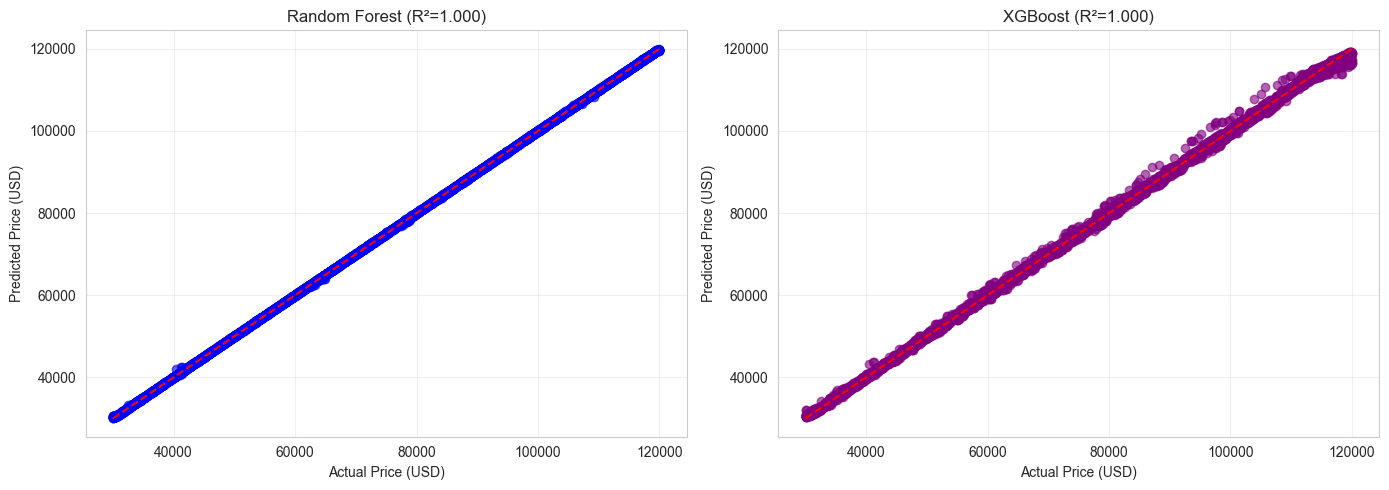

In [14]:
# Step 8 — Visual Comparison (Actual vs Predicted)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(y_test, rf_pred, alpha=0.6, color="blue")
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
axes[0].set_title(f"Random Forest (R²={rf_metrics['R²']:.3f})")
axes[1].scatter(y_test, xgb_pred, alpha=0.6, color="purple")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
axes[1].set_title(f"XGBoost (R²={xgb_metrics['R²']:.3f})")
for ax in axes:
    ax.set_xlabel("Actual Price (USD)")
    ax.set_ylabel("Predicted Price (USD)")
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [15]:
# Step 9 — Single Car Prediction Function
def predict_single_car(year, engine, mileage, model_name, region, fuel, trans):
    current_year = datetime.datetime.now().year
    car_age = max(current_year - int(year), 0)
    mph = mileage / max(car_age, 1)
    price_per_engine = df_unencoded["Price_USD"].mean() / engine
    input_df = pd.DataFrame([{
        "Engine_Size_L": engine,
        "Mileage_KM": mileage,
        "Car_Age": car_age,
        "Mileage_per_Year": mph,
        "Price_per_EngineSize": price_per_engine,
        "Model": model_name,
        "Region": region,
        "Fuel_Type": fuel,
        "Transmission": trans
    }])
    for c in cat_cols:
        if c in encoders:
            input_df[c] = encoders[c].transform(input_df[[c]]).astype(int)
    scaled_input = scaler.transform(input_df[features])
    rf_price = rf_model.predict(scaled_input)[0]
    xgb_price = xgb_model.predict(scaled_input)[0]
    avg_price = (rf_price + xgb_price) / 2
    return rf_price, xgb_price, avg_price
# Example prediction
example = df_unencoded.iloc[0]
rf_p, xgb_p, avg_p = predict_single_car(
    year=2020,
    engine=example["Engine_Size_L"],
    mileage=example["Mileage_KM"],
    model_name=example["Model"],
    region=example["Region"],
    fuel=example["Fuel_Type"],
    trans=example["Transmission"]
)
print(f" Predicted Average Price: ${avg_p:,.2f} USD")


 Predicted Average Price: $74,975.73 USD


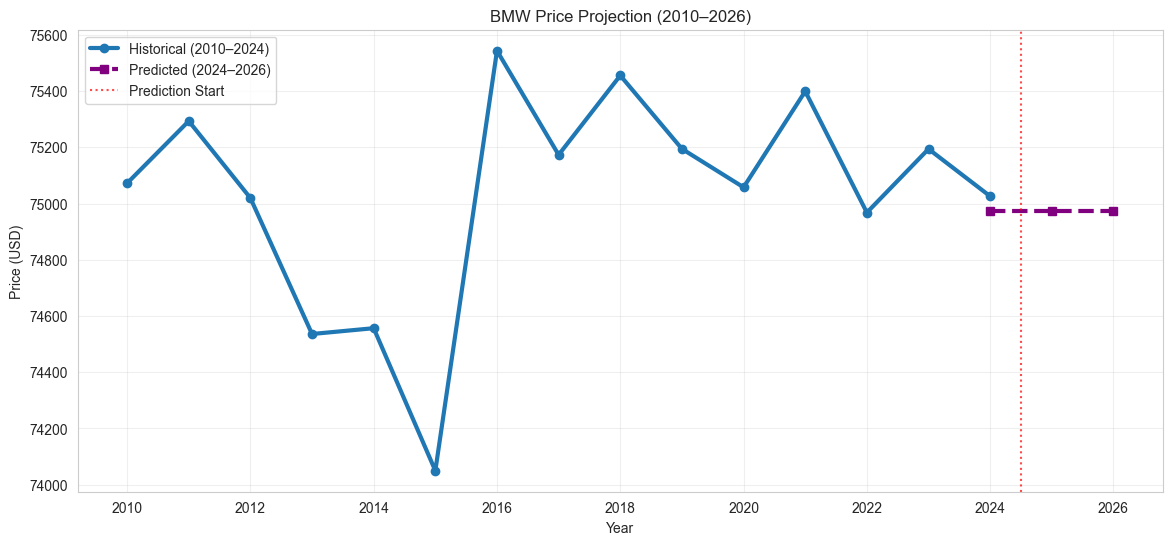

In [16]:
# Step 10 — Future Projection (2010–2026)
def future_projection(start_year, engine, mileage, model_name, region, fuel, trans):
    hist_years = list(range(2010, 2025))
    hist_prices = []
    for y in hist_years:
        if y in df_unencoded["Year"].values:
            avg_price = df_unencoded[df_unencoded["Year"] == y]["Price_USD"].mean()
            hist_prices.append(avg_price)
        else:
            hist_prices.append(np.nan)
    hist_series = pd.Series(hist_prices).interpolate().tolist()
    future_years = list(range(2024, 2027))
    preds = []
    yearly_mileage_rate = mileage / max((datetime.datetime.now().year - start_year), 1)
    for y in future_years:
        new_mileage = mileage + yearly_mileage_rate * (y - start_year)
        _, _, avg_price = predict_single_car(y, engine, new_mileage, model_name, region, fuel, trans)
        preds.append(avg_price)
    all_years = hist_years + future_years[1:]
    all_prices = hist_series + preds[1:]
    plt.figure(figsize=(14, 6))
    plt.plot(hist_years, hist_series, marker="o", linewidth=3, label="Historical (2010–2024)")
    plt.plot(future_years, preds, marker="s", linestyle="--", linewidth=3, label="Predicted (2024–2026)", color="purple")
    plt.axvline(2024.5, color="red", linestyle=":", alpha=0.7, label="Prediction Start")
    plt.xlabel("Year")
    plt.ylabel("Price (USD)")
    plt.title("BMW Price Projection (2010–2026)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
# Example projection
future_projection(2020, example["Engine_Size_L"], example["Mileage_KM"],
                  example["Model"], example["Region"], example["Fuel_Type"], example["Transmission"])
